First we import the necessary code

In [1]:
import torch
import torch.nn as nn
from src.transformer import DecoderTransformer
from src.data import random_values, create_signals, sine, cosine_squared
from src.train_eval import make_prediction
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_SEQUENCE_LENGTH = 512
TIME_STEP = 0.5 / MAX_SEQUENCE_LENGTH
MIN_OMEGA = 85
MAX_OMEGA = 115

best_model = DecoderTransformer(
    output_parameter_count=1,
    d_model=128,
    num_heads=16,
    num_layers=2,
    d_ff=512,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dropout=0.1
).to(device)

best_model.load_state_dict(torch.load("models/signal_prediction.pt", map_location=device))

<All keys matched successfully>

In [5]:
EVAL_COUNT = 256

frequencies = random_values(EVAL_COUNT, MIN_OMEGA, MAX_OMEGA)
phases = random_values(EVAL_COUNT, 0, 2 * torch.pi)
only_100 = torch.ones(EVAL_COUNT) * 100
        
sines = create_signals(
    omegas=frequencies,
    signal_function=sine,
    length=MAX_SEQUENCE_LENGTH + 1,
    time_step=TIME_STEP,
    phases=phases
)
    
cosines = create_signals(
    omegas=only_100,
    signal_function=cosine_squared,
    length=MAX_SEQUENCE_LENGTH + 1,
    time_step=TIME_STEP,
    phases=phases
)

signals = 0.7 * sines + 0.3 * cosines # we use a weighted sum to not have the signal too noisy / complex
values, next_value = signals.split((MAX_SEQUENCE_LENGTH, 1), dim=1)

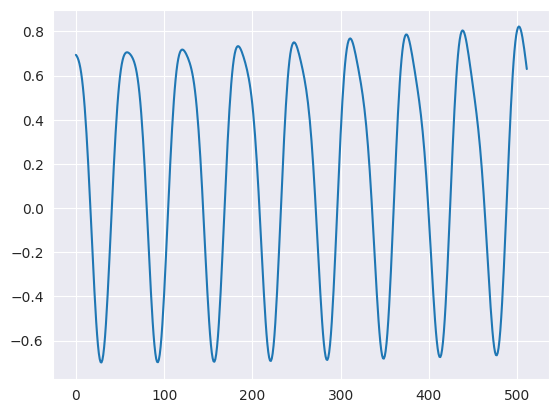

In [6]:
plt.plot(values[0])
plt.show()

Lastly, we run the values through the model and get a prediction, which we compare against the actual value.

Evaluation MAE: 0.014928


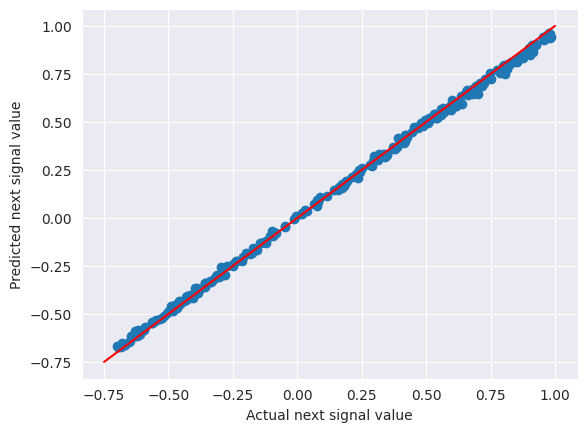

In [12]:
prediction = make_prediction(best_model, values, batch_size=16)
plt.scatter(next_value, prediction)
plt.plot([-0.75, 1], [-0.75, 1], "r")
plt.xlabel("Actual next signal value")
plt.ylabel("Predicted next signal value")
loss = nn.L1Loss()(next_value.flatten(), prediction).item()
print(f"Evaluation MAE: {loss:.6f}")

With a model that can predict the next value, we can use it like a normal LLM, but for generating the rest of the signal. Let's take a look how well the model does.

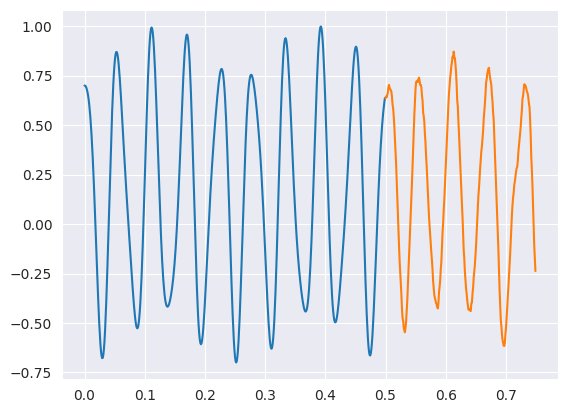

In [ ]:
from src.train_eval import predict_next_values
from src.graph import plot_prediction

index = 1
_, predicted_values = predict_next_values(best_model, values[index], MAX_SEQUENCE_LENGTH, count=MAX_SEQUENCE_LENGTH // 2)
fig = plot_prediction(values[index], predicted_values, TIME_STEP)

While the model isn't perfect, it already is able to mimic the shape quite well.